In [1]:
import numpy as np
import pandas as pd
import math
from itertools import count
from tqdm import tqdm
import threading
import os, platform
import multiprocessing
import subprocess
from queue import Empty as QueueEmpty
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
model_list_name, output_dir = 'models_mcc200quick', 'results_mcc200quick'
# model_list_name, output_dir = 'models_random', 'results_mcc200quick'
max_time = 5
n_parallel = 8
run_all = True # run all tests or only those that don't have the .log file

In [18]:
# Load models and benchmark definition
model_list = open(model_list_name+'.txt', 'r').readlines()
model_list = [ f.replace('\n', '') for f in model_list ]
model_list = [ f for f in model_list if len(f) > 0 ]
# model_list = model_list[:10]
print(len(model_list))
os.makedirs(output_dir, exist_ok=True)

9


In [19]:
def run_commands(queue, pin, pbar):
    while True:
        try:
            qe = queue.get()#block=False)
            if qe is None:
                break
            # print(qe)
            tool, test_name, args, model_fname = qe
            model_basename = model_fname.split('/')[-1]
            logfile = f'{output_dir}/{model_basename}-{test_name}.log'
            # os.remove(logfile)
            if run_all or not os.path.exists(logfile):
                # print(logfile)
                with open(logfile, 'w') as f:
                    print('****************', file=f)
                    print(f'MODEL={model_fname}\n', file=f)
                    f.flush()
                    if platform.system()=='Darwin':
                        cmd = f'gtimeout {max_time}s '
                    else:
                        cmd = f'/usr/bin/time --verbose /usr/bin/timeout {max_time}s taskset -c {2*pin} '
                    # cmd = ''
                    if tool=='sym':
                        cmd += f'../build/sym_hilbert -c -p -u {model_fname} {args} '
                    elif tool=='4ti2':
                        cmd += f'{args} {model_fname} '
                
                    try:
                        proc = subprocess.run(cmd, shell=True, stdout=f, stderr=f)
                        exitcode = proc.returncode
                    except subprocess.TimeoutExpired:
                        exitcode = 124  # timeout

                # append exit status to the log file
                with open(logfile, 'a') as f:
                    print(f'\nEXITCODE={exitcode}\n', file=f)

                if exitcode not in [0,124]:
                    print(qe, f'EXITCODE={exitcode}')
            pbar.update(1)
        except QueueEmpty:
            print('queue empty')
            break # no more commands
    # print(f'Thread {pin} ends.')

In [20]:
tests = [
    # # [ "sym",  'TestKerA',    '' ],
    # ######### Hilbert basis #########
    # # [ "4ti2", "Hil_4ti2",  "/home/elvio/4ti2/src/zsolve/hilbert" ],
    # [ "sym",  'Hil_Ga',    '-ye -nl' ],
    # [ "sym",  'Hil_GL',    '-ye -yl' ],
    # [ "sym",  'Hil_na',    '-ne -nl' ],
    # [ "sym",  'Hil_nL',    '-ne -yl' ],
    # [ "sym",  'Hil_LD',    '-ne -yl -yd' ],
    # # [ "sym",  'Hil_nP',    '-ne -yl -po' ],
    # [ "sym",  'Hil_LS',    '-ne -yl -s' ],
    # # [ "sym",  'Hil_LZ',    '-ne -yl -z' ],
    # # [ "sym",  'Hil_LZD',   '-ne -yl -z -yd' ],
    # # [ "sym",  'Hil_LZS',   '-ne -yl -z -yd -s' ],
    # [ "sym",  'Hil_HNF',   '-ne -yl -yd -np' ],
    # [ "sym",  'Hil_IGE',   '-ne -yl -yd -np -ige' ],

    # ######### Extreme Rays #########
    # # [ "4ti2", "Ray_4ti2",  "/home/elvio/4ti2/src/groebner/rays" ],
    [ "sym",  'Ray_nL',    '-ne -yl -x' ],
    # # [ "sym",  'Ray_LZ',    '-ne -yl -z -x' ],
    # # [ "sym",  'Ray_LD',    '-ne -yl -d -x' ],
    # # [ "sym",  'Ray_LZD',   '-ne -yl -z -yd -x' ],
    # # [ "sym",  'Ray_LS',    '-ne -yl -s -x' ],
    # # # [ "sym",  'Ray_LZS',   '-ne -yl -z -s -x' ],
    # # # [ "sym",  'Ray_nP',    '-ne -yl -po -x' ],

    # ######### Graver basis #########
    # # [ "4ti2", "Gra_4ti2",  "/home/elvio/4ti2/src/zsolve/graver" ],
    # [ "sym",  'Gra_Ga',    '-ye -nl -g' ],
    # [ "sym",  'Gra_na',    '-ne -nl -g' ],
    # # [ "sym",  'Gra_nL',    '-ne -yl -g' ],
    # # # [ "sym",  'Gra_nP',    '-ne -yl -po -g' ],
]
# generate commands
queue = multiprocessing.Queue(maxsize=10000)
num_runs = 0
for tool, test_name, args in tests:
    for model in model_list:
        queue.put([tool,  test_name, args, model])
        num_runs += 1
print('num_runs=',num_runs)
for i in range(n_parallel):
    queue.put(None)

num_runs= 9


In [21]:
with tqdm(total=num_runs) as pbar:
    # run the commands in parallel
    threads = []
    for i in range(n_parallel):
        threads.append(threading.Thread(target=run_commands, args=(queue, i, pbar)))
        
    for t in threads: # start all threads
        t.start()
    for t in threads: # wait for all terminations
        t.join()
queue.close()
print('Done')

100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

Done


In [22]:
data = []
for model_fname in model_list:
    model_basename = model_fname.split('/')[-1]
    row = {'model':model_basename}
    for tool, test_name, args in tests:
        logfile = f'{output_dir}/{model_basename}-{test_name}.log'
        if os.path.exists(logfile):
            tm = -1.0
            cntC = -1
            with open(logfile) as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('User time'):
                        tm = float(line.split(':')[1])
                    if line.startswith('CPU usage'):
                        tm = float(line.split(':')[1])
                    elif line.startswith('Total S-Vectors processed') or line.startswith('_completes:') or line.startswith('Added:'):
    #                     print(line, float(line.split(':')[1]))
                        cntC = int(line.split(':')[1])
                    elif line.startswith('EXITCODE'):
                        # ec = int(re.sub(' +', ' ', line).split(' ')[1])
                        ec = int(line.split('=')[1])
                        if ec==124:
                            tm = -1
                        elif ec != 0:
                            print(line, logfile)
            row[test_name] = tm
            row[test_name+'_C'] = cntC
    data.append(row)
data = pd.DataFrame(data)
data.to_csv(f'data_{model_list_name}.csv', index=False)

In [23]:
data.head(10)

,model,Ray_nL,Ray_nL_C
0,AirplaneLD-COL-0010,0,3
1,BridgeAndVehicles-PT-V04P05N02,0,0
2,BusinessProcesses-PT-01,2,989
3,CircadianClock-PT-000001,0,0
4,CircularTrains-PT-012,0,190
5,in000,1,21
6,in001,-1,-1
7,in002,0,13
8,magic3x3,0,13


In [24]:
data.head(10)

,model,Ray_nL,Ray_nL_C
0,AirplaneLD-COL-0010,0,3
1,BridgeAndVehicles-PT-V04P05N02,0,0
2,BusinessProcesses-PT-01,2,989
3,CircadianClock-PT-000001,0,0
4,CircularTrains-PT-012,0,190
5,in000,1,21
6,in001,-1,-1
7,in002,0,13
8,magic3x3,0,13


In [25]:
# # from decimal import Decimal
# data = pd.read_csv(f'data_{output_dir}.csv')
# for c in data.columns:
#     if c.endswith('_C'):
#         data[c] = pd.to_numeric(data[c])#.astype(Decimal)
#     if c.startswith('Hil_'):
#         data[c] = data[c].astype(float)

In [26]:
name_map = { 'Ga':'G*', 'na':'**', 'nL':'*L', 'nP':'*P', 'LD':'*LD', 'LS':'*LS', 
             'LZ':'*LZ', 'LZD':'*LZD', 'LZS':'*LZS', 'LZS2':'*LZS2', '4ti2':'4ti2' }

In [27]:
col_names = sorted([c for c in data.columns if '_' in c and not c.endswith('_C') ], reverse=True)

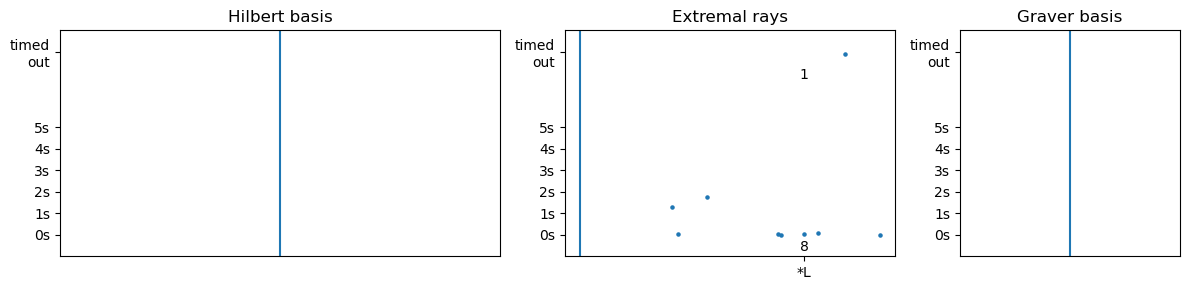

In [28]:
# vecs = [np.array(new_list[c]) for c in col_names]
fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
y_tout = 8
xx = (np.random.rand(len(data)) - 0.5) * 0.6
yy = np.random.rand(len(data)) + y_tout
for jj in range(3):
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(data[col_name])
        num_tout = np.sum(vv<0)
        vv[vv<0] = yy[vv<0]
        axes[jj].scatter(xx+i, vv, s=5)
        axes[jj].text(i, y_tout-.75, f'{num_tout}', fontsize=10, ha='center')
        axes[jj].text(i, -.75, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    axes[jj].set_title(prefix[jj][1])
    
    axes[jj].set_xticks(range(len(jj_col_names)), [name_map[c.split('_')[1]] for c in jj_col_names])
    axes[jj].set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    axes[jj].vlines(i-.5, -1, y_tout+2) 
    axes[jj].set_ylim(-1, y_tout+1.5)
plt.tight_layout()
# plt.savefig(f'{model_list_name}-time.pdf')
plt.show()

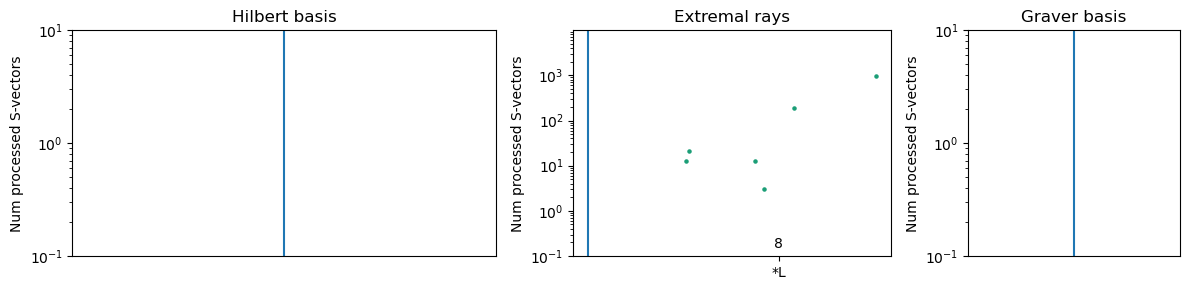

In [29]:
from matplotlib  import colormaps
cmap = colormaps['Dark2']
fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
for jj in range(3):
#     if jj==1: continue
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]# and not '4ti2' in c]
    NL = data.copy()
    y_tout = 1
    for n in jj_col_names:
        NL = NL[ NL[n+'_C'] != -1 ]
    for n in jj_col_names:
        y_tout = max(y_tout, int(NL[n+'_C'].max()))
    y_tout *= 10
    xx = (np.random.rand(len(NL)) - 0.5) * 0.6
    yy = np.random.rand(len(NL)) + y_tout
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(NL[col_name])
        vC = np.array(NL[col_name+'_C'], dtype=int)
        tout_mask = vv<0
        num_tout = np.sum(tout_mask)
#         y_tout = 1e+15
        vC[tout_mask] = yy[tout_mask]
        vC[vC < 0] = 1
        axes[jj].scatter(xx+i, vC, s=5, color=cmap(i))
#         axes[jj].text(i, y_tout-.75, f'{num_tout}', fontsize=12, ha='center')
        axes[jj].text(i, 0.15, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    axes[jj].set_title(prefix[jj][1])
    
    axes[jj].set_xticks(range(len(jj_col_names)), [name_map[c.split('_')[1]] for c in jj_col_names])
#     axes[jj].set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    axes[jj].vlines(i-.5, -1, y_tout+2) 
    axes[jj].set_ylim(0.099, y_tout) 
    axes[jj].set_yscale('log')
    axes[jj].set_ylabel('Num processed S-vectors')
plt.tight_layout()
# plt.savefig(f'{model_list_name}-svectors.pdf')
plt.show()

In [15]:
print('IGE better than HNF:')
pd.options.display.float_format = '{:,.0f}'.format
data2 = data[(data.Hil_HNF_C>=0) | (data.Hil_IGE_C>=0)].copy()
data2.Hil_HNF_C = data2.Hil_HNF_C.replace(-1, 1000000)
data2.Hil_IGE_C = data2.Hil_IGE_C.replace(-1, 1000000)
data2[ data2.Hil_HNF_C > 2*data2.Hil_IGE_C + 1 ][['model', 'Hil_HNF', 'Hil_HNF_C', 'Hil_IGE', 'Hil_IGE_C']]

IGE better than HNF:


AttributeError: 'DataFrame' object has no attribute 'Hil_HNF_C'

In [16]:
print('HNF better than IGE:')
data2[ data2.Hil_IGE_C > 2*data2.Hil_HNF_C + 1 ][['model', 'Hil_HNF', 'Hil_HNF_C', 'Hil_IGE', 'Hil_IGE_C']]

HNF better than IGE:


NameError: name 'data2' is not defined